In [1]:
from gpt2 import GPT, GPTConfig # our GPT class

import math
import time
import tiktoken
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
enc = tiktoken.get_encoding('gpt2')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # dynamic device

torch.manual_seed(13) # for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(13)

## Data Loader Lite

In [3]:
class DataLoaderLite:

    def __init__(self, B, T):

        self.B, self.T = B, T

        with open('data/input.txt', 'r') as file:
            text = file.read().replace('\n', '')
        
        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long, device=device)

        self.current_batch = 0
        self.number_of_batches = len(self.tokens) // (B * T)

        print(f'Loaded {len(self.tokens)} tokens, {self.number_of_batches} batches of size {B}x{T}')

    
    def next_batch(self):

        B, T = self.B, self.T

        buf = self.tokens[self.current_batch * B * T : (self.current_batch + 1) * B * T + 1]
        x = buf[:-1].view(B, T)
        y = buf[1:].view(B, T)

        self.current_batch += 1
        if self.current_batch >= self.number_of_batches:
            self.current_batch = 0
        
        return x, y

## Learning Rate Scheduler

In [4]:
max_lr = 6e-4
min_lr = max_lr / 10
warmup_steps = 5
num_steps = 20
def get_lr(step):
    if step < warmup_steps:
        return min_lr + (max_lr - min_lr) * step / warmup_steps
    elif step < num_steps:
        return min_lr + (max_lr - min_lr) * (1 + math.cos((step - warmup_steps) / (num_steps - warmup_steps) * math.pi)) / 2
    else:
        return min_lr

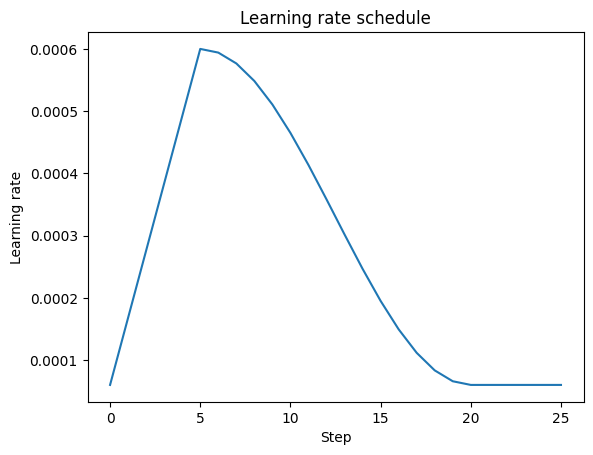

In [5]:
plt.plot([get_lr(step) for step in range(0, 25 + 1)]);
plt.title('Learning rate schedule');
plt.xlabel('Step');
plt.ylabel('Learning rate');

## Training

In [6]:
model = GPT(GPTConfig(vocab_size=50304)).to(device).train()
# model = torch.compile(model)

scaler = torch.cuda.amp.GradScaler() # create a gradient scaler for mixed precision training

B, T = 4, 1024
data_loader = DataLoaderLite(B, T)

# Create optimizer with weight decay
param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad} # all the params require grad anyways
weight_decay_params = [p for pn, p in param_dict.items() if p.dim() >= 2]
non_weight_decay_params = [p for pn, p in param_dict.items() if p.dim() < 2]
optim_groups = [
    {'params': weight_decay_params, 'weight_decay': 0.01},
    {'params': non_weight_decay_params, 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optim_groups, lr=1, betas=(0.9, 0.95), eps=1e-8, fused=True)

for step in range(25):
    t0 = time.time()

    # forward pass
    x, y = data_loader.next_batch()
    optimizer.zero_grad()
    with torch.autocast(device_type=device.type, dtype=torch.float16):
        logits, loss = model(x, y)
    
    # learning rate schedule
    lr = get_lr(step)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # backward pass
    scaler.scale(loss).backward()

    # optimizer step
    scaler.unscale_(optimizer)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()
    
    # track throughput
    torch.cuda.synchronize() # wait for GPU to finish work
    t1 = time.time()
    dt = (t1 - t0) * 1000 # time difference in milliseconds
    thoughput = (B * T) / (t1 - t0) # tokens per second

    # print stats
    print(f"step {step:4d} | loss {loss.item():.6f} | lr: {lr:.4f} | norm: {norm:.4f} | dt: {dt:.2f} ms | throughput: {thoughput:.2f} tok/s")

Loaded 297884 tokens, 72 batches of size 4x1024
step    0 | loss 10.944057 | lr: 0.0001 | norm: 18.2486 | dt: 542.85 ms | throughput: 7545.30 tok/s
step    1 | loss 10.084132 | lr: 0.0002 | norm: 7.0106 | dt: 225.30 ms | throughput: 18180.33 tok/s
step    2 | loss 9.689094 | lr: 0.0003 | norm: 3.0819 | dt: 299.82 ms | throughput: 13661.55 tok/s
step    3 | loss 9.530628 | lr: 0.0004 | norm: 3.0705 | dt: 247.14 ms | throughput: 16573.83 tok/s
step    4 | loss 9.058435 | lr: 0.0005 | norm: 2.1522 | dt: 245.46 ms | throughput: 16687.18 tok/s
step    5 | loss 8.658066 | lr: 0.0006 | norm: 1.9799 | dt: 239.17 ms | throughput: 17126.16 tok/s
step    6 | loss 8.241713 | lr: 0.0006 | norm: 1.9244 | dt: 244.20 ms | throughput: 16772.89 tok/s
step    7 | loss 7.963754 | lr: 0.0006 | norm: 1.5693 | dt: 248.55 ms | throughput: 16479.63 tok/s
step    8 | loss 7.474359 | lr: 0.0005 | norm: 1.3671 | dt: 249.75 ms | throughput: 16400.41 tok/s
step    9 | loss 7.405852 | lr: 0.0005 | norm: 4.9415 | dt: